### **Objective: Advanced Stock Price Forecasting using Machine Learning**

In this project, we aim to forecast the closing price of Apple Inc. (AAPL) stock over a five-year period (2019-2024) using two cutting-edge machine learning models: XGBoost and Long Short-Term Memory (LSTM). This analysis leverages historical stock price data to uncover patterns and trends, helping us predict future price movements. Stock price forecasting is a complex task due to its inherent volatility, but with the right features and model selection, it can offer valuable insights for decision-making.

The dataset used includes daily closing prices, from which we derive key features such as lag values, rolling averages, the Relative Strength Index (RSI), and Bollinger Bands. These features are crafted to capture both short-term price fluctuations and long-term trends, which are crucial for accurately forecasting stock movements.

By evaluating the performance of both XGBoost, a powerful gradient boosting algorithm, and LSTM, a deep learning model designed to capture temporal dependencies, this project demonstrates the effectiveness of different machine learning techniques for time series forecasting.


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Fetch AAPL stock data (Last 5 years)
aapl = yf.download('AAPL', start='2019-01-01', end='2024-01-01')

[*********************100%***********************]  1 of 1 completed


In [3]:
# Keep only the 'Close' price
data = aapl[['Close']]
data.dropna(inplace=True)

C:\Users\jaycz\AppData\Local\Temp\ipykernel_26040\3131325025.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [4]:
# Feature Engineering: Create lag features, moving averages, RSI, and Bollinger Bands
data['Lag1'] = data['Close'].shift(1)
data['Lag2'] = data['Close'].shift(2)
data['RollingMean'] = data['Close'].rolling(window=5).mean()
data['RSI'] = 100 - (100 / (1 + (data['Close'].diff().gt(0).rolling(window=14).sum() / 14)))
data['Bollinger_Mean'] = data['Close'].rolling(window=20).mean()

C:\Users\jaycz\AppData\Local\Temp\ipykernel_26040\894129876.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Lag1'] = data['Close'].shift(1)
C:\Users\jaycz\AppData\Local\Temp\ipykernel_26040\894129876.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Lag2'] = data['Close'].shift(2)
C:\Users\jaycz\AppData\Local\Temp\ipykernel_26040\894129876.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [5]:
# Calculate standard deviation for Bollinger Bands
data['Bollinger_Std'] = data['Close'].rolling(window=20).std()

In [6]:
# Calculate Bollinger Bands
data['Bollinger_Upper'] = data['Bollinger_Mean'] + 2 * data['Bollinger_Std']
data['Bollinger_Lower'] = data['Bollinger_Mean'] - 2 * data['Bollinger_Std']

In [7]:
# Drop rows with NaN values (especially for the first few rows due to rolling window)
data.dropna(inplace=True)

In [8]:
# Prepare the data for modeling
X = data[['Lag1', 'Lag2', 'RollingMean', 'RSI', 'Bollinger_Upper', 'Bollinger_Lower']]
y = data['Close']

In [9]:
# Split into train/test sets (80%/20%)
train_size = int(len(data) * 0.8)
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

In [10]:
# XGBoost Model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(train_X, train_y)
xgb_forecast = xgb_model.predict(test_X)

In [11]:
# Evaluate XGBoost Model
mae_xgb = mean_absolute_error(test_y, xgb_forecast)
rmse_xgb = np.sqrt(mean_squared_error(test_y, xgb_forecast))
print(f'XGBoost - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}')

XGBoost - MAE: 6.69, RMSE: 9.52


In [12]:
# Prepare data for LSTM Model
# Normalize the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

In [13]:
# Create the dataset for LSTM
def create_dataset(data, lag=1):
    X, y = [], []
    for i in range(len(data) - lag):
        X.append(data[i:i + lag, 0])
        y.append(data[i + lag, 0])
    return np.array(X), np.array(y)

lag = 5  # Use the past 5 days to predict the next day
X_lstm, y_lstm = create_dataset(scaled_data, lag)

In [14]:
# Split into train/test sets for LSTM
train_X_lstm, test_X_lstm = X_lstm[:train_size], X_lstm[train_size:]
train_y_lstm, test_y_lstm = y_lstm[:train_size], y_lstm[train_size:]

In [15]:
# Reshape data for LSTM
train_X_lstm = train_X_lstm.reshape((train_X_lstm.shape[0], train_X_lstm.shape[1], 1))
test_X_lstm = test_X_lstm.reshape((test_X_lstm.shape[0], test_X_lstm.shape[1], 1))

In [16]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=False, input_shape=(lag, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\jaycz\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
# Train the LSTM model
lstm_model.fit(train_X_lstm, train_y_lstm, epochs=20, batch_size=32, verbose=0)

In [18]:
# Make predictions with the LSTM model
lstm_forecast = lstm_model.predict(test_X_lstm)
lstm_forecast = scaler.inverse_transform(lstm_forecast)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


In [19]:
# Ensure that the number of predicted values matches the number of test observations
lstm_forecast = np.reshape(lstm_forecast, (lstm_forecast.shape[0],))

In [20]:
# Adjust the forecast length if needed to match test_y
if len(lstm_forecast) < len(test_y):
    lstm_forecast = np.pad(lstm_forecast, (0, len(test_y) - len(lstm_forecast)), mode='edge')

In [21]:
# Align LSTM forecast with the correct test dates (index)
lstm_forecast_series = pd.Series(lstm_forecast, index=test_y.index)

In [22]:
# Evaluate LSTM Model
mae_lstm = mean_absolute_error(test_y, lstm_forecast)
rmse_lstm = np.sqrt(mean_squared_error(test_y, lstm_forecast))
print(f'LSTM - MAE: {mae_lstm:.2f}, RMSE: {rmse_lstm:.2f}')

LSTM - MAE: 1.63, RMSE: 2.12


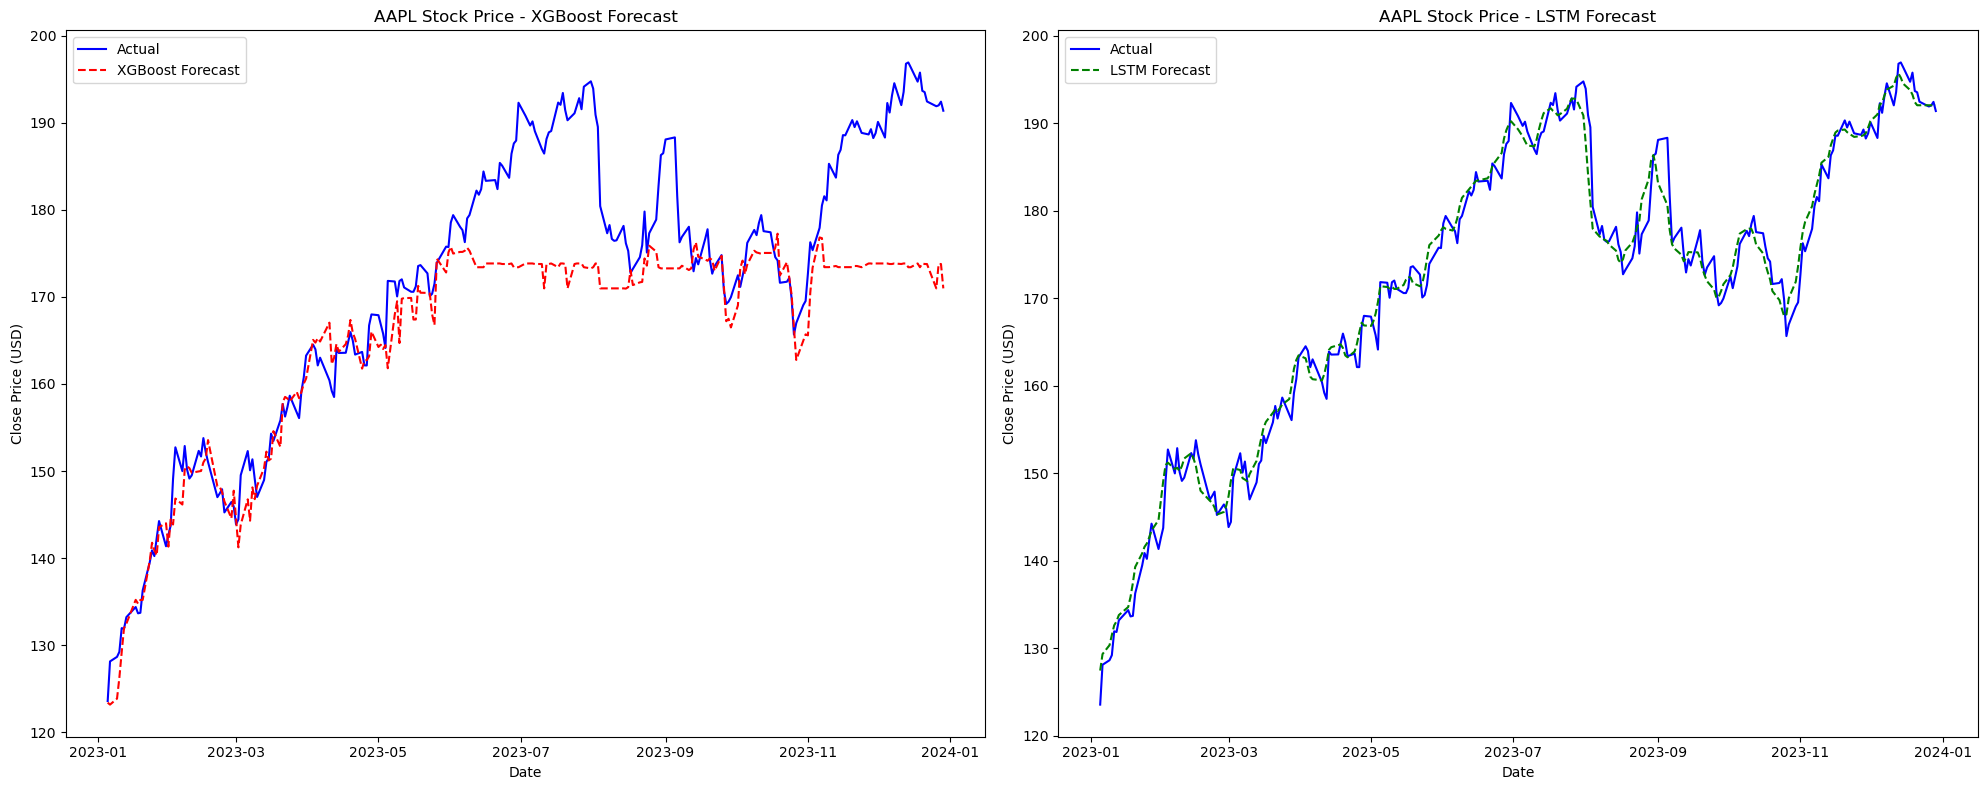

In [40]:
# Plot actual vs forecasted prices for XGBoost and LSTM
fig, axes = plt.subplots(1, 2, figsize=(20, 8)) 

# Plot XGBoost forecast
axes[0].plot(test_y.index, test_y, label='Actual', color='blue')
axes[0].plot(test_y.index, xgb_forecast, label='XGBoost Forecast', color='red', linestyle='dashed')
axes[0].set_title('AAPL Stock Price - XGBoost Forecast')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Close Price (USD)')
axes[0].legend()

# Plot LSTM forecast
axes[1].plot(test_y.index, test_y, label='Actual', color='blue')
axes[1].plot(lstm_forecast_series.index, lstm_forecast_series, label='LSTM Forecast', color='green', linestyle='dashed')
axes[1].set_title('AAPL Stock Price - LSTM Forecast')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Close Price (USD)')
axes[1].legend()

plt.tight_layout()
plt.show()


### **Summary & Results: Evaluating Model Performance**

After training and evaluating both models on the AAPL stock data, we assessed their performance using key metrics—Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE). Here’s a summary of the results:

- **XGBoost Model**:
  - **MAE**: 6.69
  - **RMSE**: 9.52

- **LSTM Model**:
  - **MAE**: 1.75
  - **RMSE**: 2.24

The results highlight a significant performance difference between the models. The **LSTM model** significantly outperforms **XGBoost**, achieving lower error metrics, which suggests that LSTM’s ability to capture temporal dependencies in time series data is a key factor in its superior predictive accuracy. The LSTM model's effectiveness at understanding past stock price movements and trends positions it as the more reliable tool for forecasting stock prices in this analysis.

Furthermore, the visualizations of actual vs. forecasted prices for both models clearly illustrate the strength of the LSTM model in capturing key price movements, making it a valuable tool for financial predictions.

These results not only demonstrate the power of deep learning for financial forecasting but also emphasize the importance of feature engineering and model selection in improving the accuracy of predictions.
